In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
c

Client Scheduler: tcp://127.0.0.1:38189 Dashboard: http://127.0.0.1:35022/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


In [3]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
import numpy.ma as ma

today=date.today()

#pip install windrose 
from windrose import WindroseAxes
import matplotlib.pyplot as plt


import seaborn as sns
sns.set(color_codes=True)

#https://pmall.univ-grenoble-alpes.fr/docs/auto_examples_code/windrose/windrose-exemple.html

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/windrose/windrose.py:29: MatplotlibDeprecationWarning: 
The Appender class was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  addendum = docstring.Appender(msg, "\n\n")
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The copy_dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use docstring.copy() and cbook.dedent() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.getdoc() instead.
  return lambda func: addendum(docstring.copy_dedent(base)(func))
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/windrose/windrose.py:30: MatplotlibDeprec

In [4]:
#GS
#imin = 994
#imax = 1295
#jmin = 751
#jmax = 1155
#NE
#imin = 3838
#imax = 4119
#jmin = 1783
#jmax = 2239
#AC
imin = 3088
imax = 3386
jmin = 301
jmax = 657

In [5]:
def dx_var(data,e1):
    dx_var = (data.shift(x=-1) - data)/e1
    return dx_var
def dy_var(data,e2):
    dy_var = (data.shift(x=-1) - data)/e2
    return dy_var
    

In [6]:
data_dir = '/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1m'
gridfile='/store/molines/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc'
dsgrid=xr.open_dataset(gridfile,chunks={'x':1000,'y':1000})

In [7]:
e1=dsgrid['e1t'][0]
e2=dsgrid['e2t'][0]

year='2013'
month='03'
filename = sorted(glob.glob(data_dir+'/NATL60-CJM165_y'+str(year)+'m'+str(month)+'.1m_gridTsurf.nc'))


In [8]:
file=filename[0]
print(file)
ds=xr.open_dataset(file,chunks={'x':1000,'y':1000,'time_counter':1})
dataT=ds['sosstsst']
dataS=ds['sosaline']
dataT_dx=dx_var(dataT,e1)
dataS_dx=dx_var(dataS,e1)
dataT_dy=dy_var(dataT,e1)
dataS_dy=dy_var(dataS,e1)
R=(dataT_dx + 1j * dataT_dy)/(dataS_dx + 1j * dataS_dy)
magR=np.abs(R)
magR_ma=ma.masked_invalid(magR)
Tu=np.arctan(magR)



/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1m/NATL60-CJM165_y2013m03.1m_gridTsurf.nc


In [9]:
magR_box=magR[:,jmin:jmax,imin:imax].stack(z=('x', 'y','time_counter'))
Tu_box=Tu[:,jmin:jmax,imin:imax].stack(z=('x', 'y','time_counter'))
    
magR_box_nonan=magR_box[~np.isnan(magR_box)]
Tu_box_nonan=Tu_box[~np.isnan(magR_box)]
magR_box_nonan_noinf=magR_box_nonan[~np.isinf(magR_box_nonan)]
Tu_box_nonan_noinf=Tu_box_nonan[~np.isinf(magR_box_nonan)]


In [10]:
magR_box_nonan_noinf=magR_box_nonan_noinf.reset_index('z')
dataset_mag=magR_box_nonan_noinf.to_dataset(name='magR')
dataset_mag.attrs['global_attribute']= 'Stack of absolute value of ratio between temperature and salinity gradient of data for day '+str(date)
dataset_mag.to_netcdf(path='/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1m/NATL60-CJM165_magR_y'+str(year)+'m'+str(month)+'.1m_AC.nc',mode='w')


In [11]:
Tu_box_nonan_noinf=Tu_box_nonan_noinf.reset_index('z')
dataset_mag=Tu_box_nonan_noinf.to_dataset(name='Tu')
dataset_mag.attrs['global_attribute']= 'Stack of turner angle of data for day '+str(date)
dataset_mag.to_netcdf(path='/scratch/cnt0024/hmg2840/albert7a/NATL60/NATL60-CJM165-S/1m/NATL60-CJM165_Tu_y'+str(year)+'m'+str(month)+'.1m__AC.nc',mode='w')


Text(0.5, 1.0, 'turner angle - AC box -2013 03')

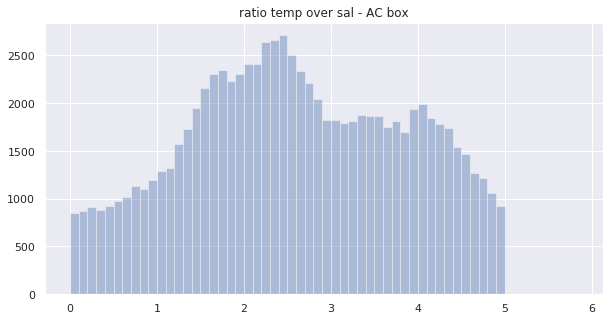

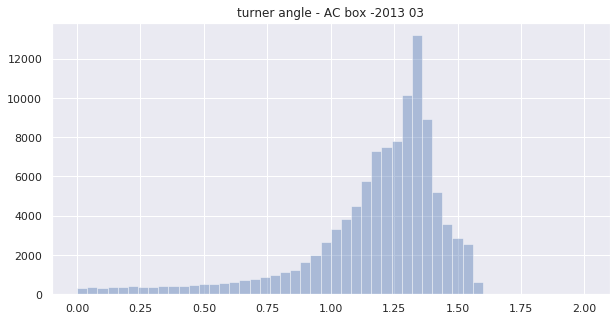

In [12]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes()    # creates the axes of specified dimensions

sns.distplot(magR_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,5]})
plt.title('ratio temp over sal - AC box')

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_axes()    # creates the axes of specified dimensions

sns.distplot(Tu_box_nonan_noinf,hist=True, kde=False,hist_kws={"range": [0,2]})
plt.title('turner angle - AC box -'+str(year)+' '+str(month))


distributed.nanny - WARNING - Worker process 9811 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 9816 was killed by signal 9
distributed.nanny - WARNING - Restarting worker


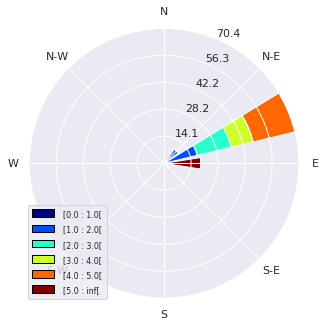

distributed.nanny - WARNING - Worker process 9803 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 9805 was killed by signal 9
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 9818 was killed by signal 9
distributed.nanny - WARNING - Restarting worker


In [13]:
fig = plt.figure(figsize=(10, 5))

rectangle = [0.1, 0.1, 0.75, 0.75]
ax = WindroseAxes(fig,rectangle)
fig.add_axes(ax)
ax.bar(Tu_box_nonan_noinf[0:1500]*180/np.pi, magR_box_nonan_noinf[0:1500], normed=True, opening=0.8, edgecolor='white', bins=np.arange(0,6, 1))
#ax.set_title("annual", position=(0.5, 1.1))

ax.set_legend()
#ax.legend(title="wind speed (m/s)", loc=(1.1, 0))